In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import FactorAnalysis, PCA
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac

# import some useful functions (they are available in utils.py)
from utils import *

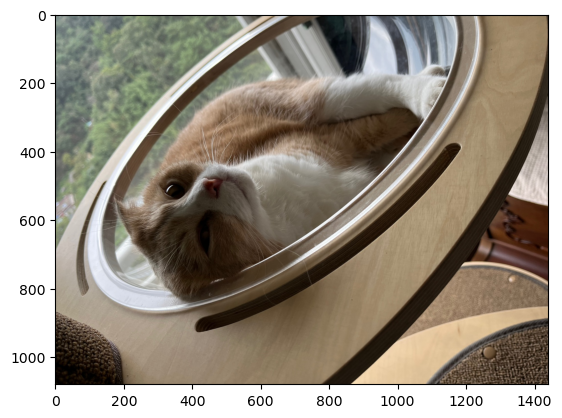

In [2]:
image = plt.imread("KakaoTalk_20240113_004808842.jpg")
plt.imshow(image)

In [3]:
def decompose_three_way(tensor, rank, max_iter=501, verbose=False):

    # a = np.random.random((rank, tensor.shape[0]))
    b = np.random.random((rank, tensor.shape[1]))
    c = np.random.random((rank, tensor.shape[2]))

    for epoch in range(max_iter):
        # optimize a
        input_a = khatri_rao([b.T, c.T])
        target_a = tl.unfold(tensor, mode=0).T
        a = np.linalg.solve(input_a.T.dot(input_a), input_a.T.dot(target_a))

        # optimize b
        input_b = khatri_rao([a.T, c.T])
        target_b = tl.unfold(tensor, mode=1).T
        b = np.linalg.solve(input_b.T.dot(input_b), input_b.T.dot(target_b))

        # optimize c
        input_c = khatri_rao([a.T, b.T])
        target_c = tl.unfold(tensor, mode=2).T
        c = np.linalg.solve(input_c.T.dot(input_c), input_c.T.dot(target_c))

        if verbose and epoch % int(max_iter * .2) == 0:
            res_a = np.square(input_a.dot(a) - target_a)
            res_b = np.square(input_b.dot(b) - target_b)
            res_c = np.square(input_c.dot(c) - target_c)
            print("Epoch:", epoch, "| Loss (C):", res_a.mean(), "| Loss (B):", res_b.mean(), "| Loss (C):", res_c.mean())

    return a.T, b.T, c.T

In [5]:
a, b, c = decompose_three_way(image, 30)

In [4]:
def reconstruct(factors, rank=None):
    a, b, c = factors
    rank = rank if rank else a.shape[1]
    R1s = np.zeros((a.shape[0], b.shape[0], c.shape[0], rank))
    for i in range(rank):
        R1s[:, :, :, i] = rank_one_tensor(a[:, i], b[:, i], c[:, i])
    return R1s.sum(axis=3)

def rank_one_tensor(a, b, c):
    """Returns a rank 1 tensor, given three vectors  
    """
    a = a.reshape(-1, 1).astype(np.float32)
    b = b.reshape(-1, 1).astype(np.float32)
    c = c.reshape(-1, 1).astype(np.float32)
    return np.tensordot(a * b.T, c, axes=0)[:, :, :, 0]

In [6]:
M_np = reconstruct((a, b, c))

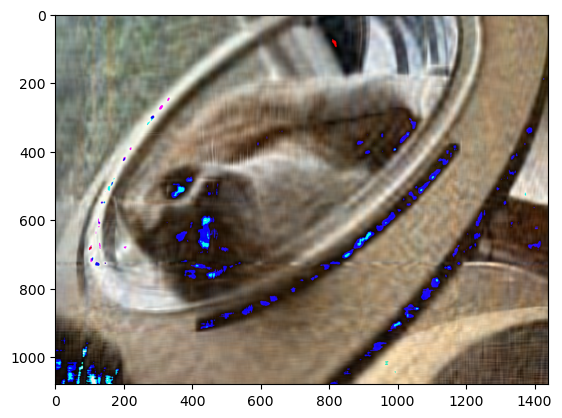

In [20]:
plt.imshow(M_np.astype(np.uint8))

In [21]:
u, s, vh = np.linalg.svd(image)

In [22]:
print(u.shape)
print(s.shape)
print(vh.shape)

(1080, 1440, 1440)
(1080, 3)
(1080, 3, 3)


In [ ]:
b_ = (u[...,:,:s.shape[-1]] * s[...,None,:]) @ vh[..., :s.shape[-1],:]
assert np.allclose(image, b_)

In [ ]:
plt.imshow(b_.astype(np.uint8))